Assignment 1: Power Calendar function

In [1]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime

In [2]:
def get_hours(iso, peak_type, period):
    # Determine the period
    if 'A' in period:
        year = period.split('A')[0]
        start_date = pd.Timestamp(year)
        end_date = start_date + pd.DateOffset(years=1)
    elif 'Q' in period:
        year, quarter = period.split('Q')
        start_date = pd.Timestamp(year) + pd.DateOffset(months=(int(quarter)-1)*3)
        end_date = start_date + pd.DateOffset(months=3)
    elif '-' in period:
        start_date = pd.Timestamp(period)
        end_date = start_date + pd.DateOffset(days=1)
    else:
        year, month = period[:-3], period[-3:]
        start_date = pd.Timestamp(year+'-'+month)
        end_date = start_date + pd.DateOffset(months=1)
        
    # Define the weekdays and hours based on iso
    eastern_isos = ['PJM', 'MISO', 'ERCOT', 'SPP', 'NYISO']
    western_isos = ['WECC', 'CAISO']
    weekdays = [0,1,2,3,4,5] if iso in western_isos else [0,1,2,3,4] # Monday=0, Sunday=6
    hours = list(range(6,22)) if iso != 'MISO' else list(range(7,23))
    nerc_holidays = USFederalHolidayCalendar().holidays(start_date, end_date)
    
    # Create dateframe
    date = pd.date_range(start_date, end_date, freq='H')
    df = pd.DataFrame(date, columns=['date'])
    df['weekday'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    df['holiday'] = df['date'].dt.date.astype('datetime64[ns]').isin(nerc_holidays)
    
    # Determine the peak hours
    if peak_type == 'onpeak':
        df['peak'] = (~df['holiday'] & df['weekday'].isin(weekdays) & df['hour'].isin(hours))
    elif peak_type == 'offpeak':
        df['peak'] = ~(~df['holiday'] & df['weekday'].isin(weekdays) & df['hour'].isin(hours))
    elif peak_type == 'flat':
        df['peak'] = 1
    elif peak_type == '2x16H':
        df['peak'] = (df['weekday'].isin([5,6]) | df['holiday']) & df['hour'].isin(hours)
    elif peak_type == '7x8':
        df['peak'] = ~df['hour'].isin(hours)
        
    num_hours = df['peak'].sum()
    
    return {'iso': iso, 'peak.type': peak_type, 'start.date': str(start_date.date()), 'end.date': str((end_date + pd.DateOffset(days=-1)).date()), 'num.hour': num_hours}

In [3]:
get_hours("ERCOT", "onpeak", "2019May")

{'iso': 'ERCOT',
 'peak.type': 'onpeak',
 'start.date': '2019-05-01',
 'end.date': '2019-05-31',
 'num.hour': 352}

Assignment 2: Meter Data formatting

In [4]:
import numpy as np
import pandas as pd
from dfply import *
from datetime import datetime
from matplotlib import pyplot as plt

C:\Users\14196\AppData\Local\Temp\ipykernel_7380\3646793121.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['TotalConsumption'] = df.sum(axis=1)


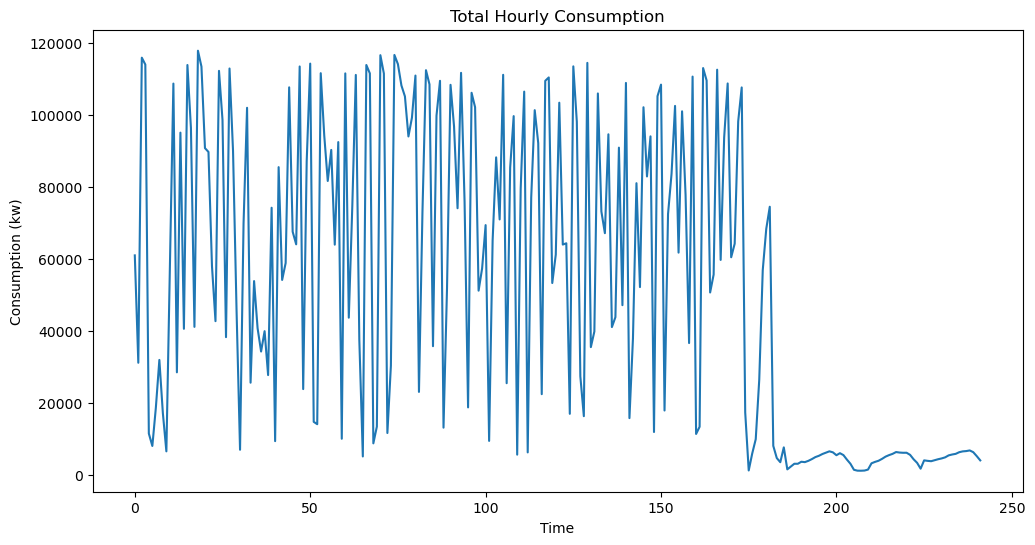

Hourly Pattern:
 Date/Time
1      3509.640241
2      1085.828132
3     32606.966032
4     16019.739910
5      3897.735410
6      6027.319169
7     11106.121680
8     18246.008348
9     25184.222952
10    31277.672462
11    74693.658028
12    89422.982217
13    45407.009045
14    38495.514176
15    24528.408290
16    13306.201794
17     9374.450357
18    12646.485157
19     8757.353849
20     6291.995685
21     5704.938937
22     4528.808168
23     3409.060787
Name: TotalConsumption, dtype: float64
Weekday Pattern:
 Date/Time
0    38836.168496
1    66795.493336
2    58220.210037
3    37912.792440
4    40094.055663
5    73698.255930
6    75765.065141
Name: TotalConsumption, dtype: float64
Monthly Pattern:
 Date/Time
6    64479.551478
7    72555.610758
8    75982.498248
9     7648.751098
Name: TotalConsumption, dtype: float64


In [5]:
#load data
base_data = pd.read_csv('C:\\Users\\14196\\Desktop\\study\\Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv')
appl_data = pd.read_csv('C:\\Users\\14196\\Desktop\\study\\Assignment 2 - new.app4.csv')

#merge dataframe
def transform_date(date_string):
    date = pd.to_datetime(date_string)
    date = date.replace(minute=0)
    return date.strftime('%m/%d %H:00:00')
appl_data['Date/Time'] = appl_data['time'].apply(transform_date)
appl_datau = appl_data[['W_min','Date/Time']].groupby('Date/Time').sum().reset_index()
base_datau = base_data.set_index('Date/Time') * 1000
base_datau = base_datau.reset_index()
base_datau['Date/Time'] = base_datau['Date/Time'].apply(lambda x: x.replace('  ', ' ')[1:])
df = pd.merge(appl_datau, base_datau,on = 'Date/Time')
df['TotalConsumption'] = df.sum(axis=1)

#plot
plt.figure(figsize=(12, 6))
plt.plot(df['TotalConsumption'])
plt.title('Total Hourly Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption (kw)')
plt.show()

#summarize any pattern observed from the data by hourl/weekday/month
df['Date/Time'] = df['Date/Time'].apply(lambda x: pd.to_datetime(x, format='%m/%d %H:%M:%S'))
df.set_index('Date/Time', inplace=True)
hourly_pattern = df.groupby(df.index.hour)['TotalConsumption'].mean()
weekday_pattern = df.groupby(df.index.weekday)['TotalConsumption'].mean()
monthly_pattern = df.groupby(df.index.month)['TotalConsumption'].mean()
print('Hourly Pattern:\n', hourly_pattern)
print('Weekday Pattern:\n', weekday_pattern)
print('Monthly Pattern:\n', monthly_pattern)


Assignment 3: EDA and forecast model

In [6]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [7]:
timedata = pd.read_excel('C:\\Users\\14196\\Desktop\\study\\Assignment 3 - timeseries_data.xlsx')

In [8]:
timedata.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


In [9]:
tdata = timedata.iloc[:,:5].rename(columns={"HB_NORTH (RTLMP)": "RTLMP", "ERCOT (WIND_RTI)": "WIND_RTI", "ERCOT (GENERATION_SOLAR_RT)": "GENERATION_SOLAR_RT","ERCOT (RTLOAD)": "RTLOAD"})

In [10]:
tdata.head()

,DATETIME,RTLMP,WIND_RTI,GENERATION_SOLAR_RT,RTLOAD
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413


Create Exploratory Data Analysis (EDA)

In [11]:
tdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATETIME             14987 non-null  datetime64[ns]
 1   RTLMP                14987 non-null  float64       
 2   WIND_RTI             14982 non-null  float64       
 3   GENERATION_SOLAR_RT  14983 non-null  float64       
 4   RTLOAD               14987 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 585.6 KB


In [12]:
tdata.describe()

,RTLMP,WIND_RTI,GENERATION_SOLAR_RT,RTLOAD
count,14987.000000,14982.000000,14983.000000,14987.000000
mean,25.766417,7532.436283,291.989714,42371.673703
std,46.361945,3992.884834,370.914596,9874.339631
min,-17.860000,54.440000,0.000000,25566.511248
25%,18.041250,4135.630000,0.000000,35431.636526
50%,20.057500,7281.445000,22.150000,39934.007113
75%,25.030000,10851.647500,608.635000,47873.100786
max,2809.357500,20350.400000,1257.540000,73264.662123


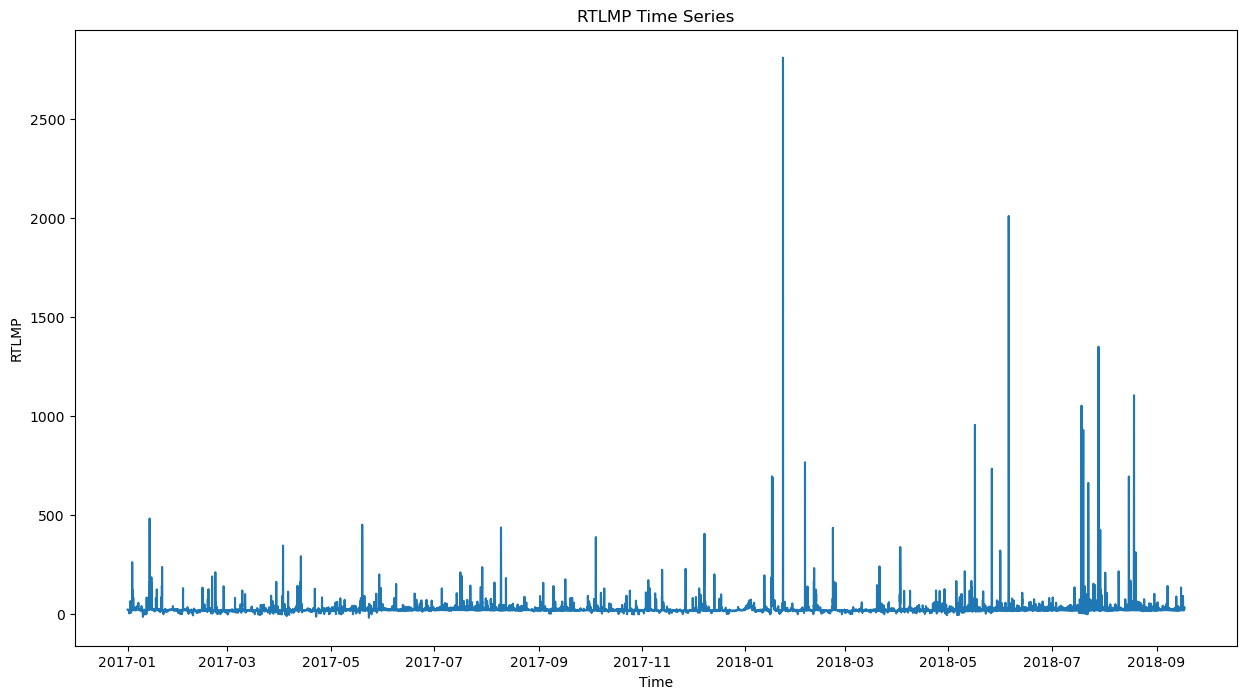

In [13]:
plt.figure(figsize=(15,8))
plt.plot(tdata['DATETIME'], tdata['RTLMP'])
plt.title('RTLMP Time Series')
plt.xlabel('Time')
plt.ylabel('RTLMP')
plt.show()

In [14]:
tdata.corr()

,RTLMP,WIND_RTI,GENERATION_SOLAR_RT,RTLOAD
RTLMP,1.000000,-0.151163,0.151922,0.238509
WIND_RTI,-0.151163,1.000000,-0.235325,-0.166760
GENERATION_SOLAR_RT,0.151922,-0.235325,1.000000,0.466350
RTLOAD,0.238509,-0.166760,0.466350,1.000000


Create forecast model to predict RTLMP

In [15]:
#ARIMA model 
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate p, d and q
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

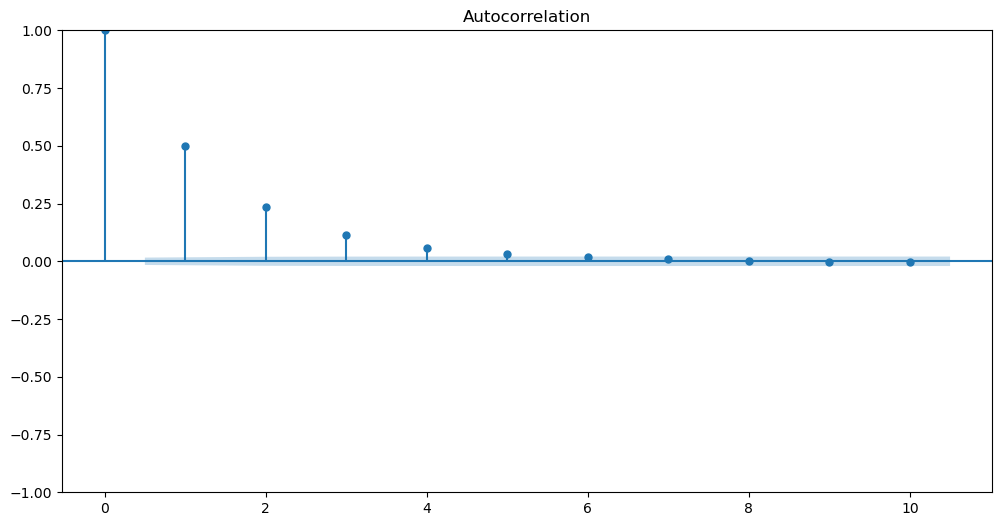

D:\Ana\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


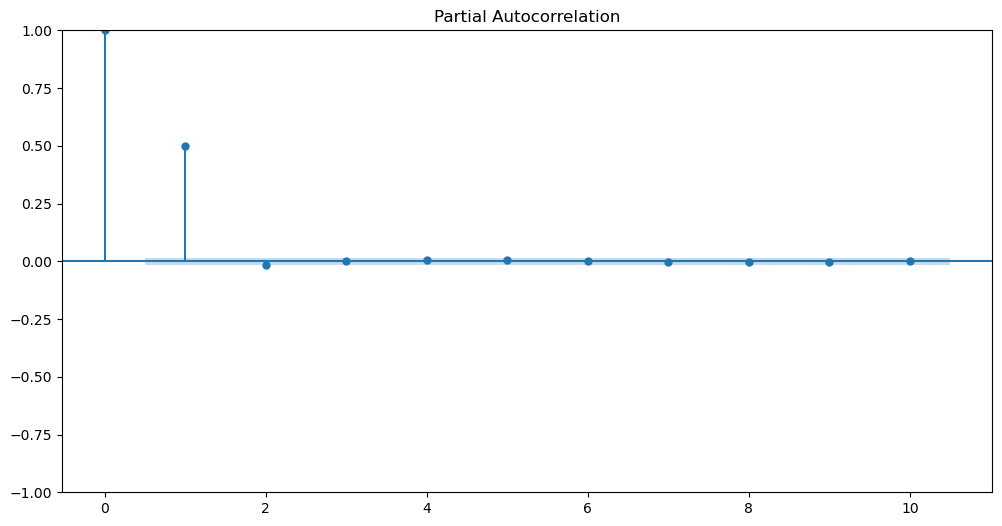

In [16]:
# Plot ACF
plt.figure(figsize=(12,6))
plot_acf(tdata['RTLMP'], lags=10, ax=plt.gca())
plt.show()

# Plot PACF
plt.figure(figsize=(12,6))
plot_pacf(tdata['RTLMP'], lags=10, ax=plt.gca())
plt.show()

In [ ]:
series = tdata['RTLMP']
# evaluate parameters
p_values = range(3)
d_values = range(4,8)
q_values = range(3)
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 4, 0) RMSE=222.871


D:\Ana\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
